In [1]:
# training and evaluate a ML model realised in Tensorflow 2
# dataset source: https://data.mendeley.com/datasets/rscbjbr9sj/2
# the dataset contains two categories: Normal and Pneumonia
# in the case of Pneumania, the origin can be Virus or Bacteria
# in this notebook, we define a ML model and we train it using
# the dataset modified
# we control the training using K-fold cross-validation

In [2]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # using only cpu
import glob
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as tkl
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
source_path = "/content/gdrive/MyDrive/ML-datasets/Chest_X_Ray/chest_xray_preprocess/"
# labels
labels = ["normal", "bacteria", "virus"]
# defining the dimensions of each image in grayscale
image_h = 224
image_w = 224
image_c = 1

In [6]:
# preparing the dataset 
builder = tfds.ImageFolder(source_path, shape=[image_h, image_w, image_c])
print(builder.info)

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(224, 224, 1), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=5856,
    splits={
        'train': 5856,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



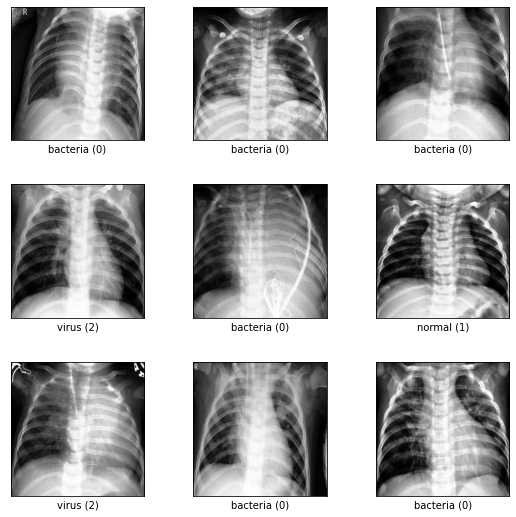

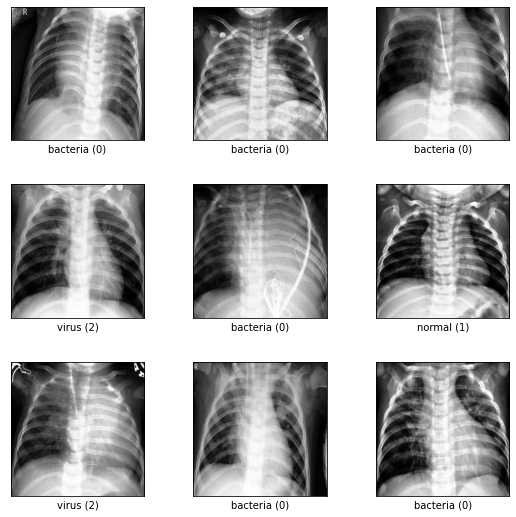

In [7]:
# creation of the dataset and showing some examples
ds = builder.as_dataset(split='train', shuffle_files=True)
tfds.show_examples(ds, builder.info)

In [ ]:
# We create a generic ML model based on a CNN. The number of layers are fixed by input parameters in the form of list. 

In [8]:
# creation of a ML model
def ML_model(input_shape, nb_of_classes, CNN_blocks=[32], 
             activation_fct='relu', pad="valid", dropout=0.5,
             linear_part=[64],
             activation_fct2='relu'):
    model = Sequential()
    model.add(tkl.InputLayer(input_shape=input_shape, name='image'))
    
    # defining the CNN part of the model
    for ch in CNN_blocks:
        model.add(tkl.Conv2D(ch, (5, 5), padding=pad))
        model.add(tkl.Activation(activation_fct))
        # model.add(tkl.BatchNormalization())
        model.add(tkl.Dropout(dropout))
        model.add(tkl.MaxPooling2D((2, 2), strides=(2, 2)))
             
    # defining the linear part of the model
    model.add(tkl.Flatten())
    for dim in linear_part:
        model.add(tkl.Dense(dim))
        model.add(tkl.Activation(activation_fct2))
    
    # last layers
    model.add(tkl.Dense(nb_of_classes))
    model.add(tkl.Activation("softmax"))
    return model

In [ ]:
# The preprocessing function is to cast image and label into TF tensors. 
# The function *grayscale* ensure that the channel number is 1

In [9]:
def preprocess_1(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    image /= 255.0
    return image, label

In [10]:
batch_size = 32  #128
ds = tf.keras.utils.image_dataset_from_directory(
  source_path + 'train/',
  # validation_split=0.01,
  # subset="training",
  shuffle=True,
  seed=77993,
  image_size=(image_h, image_w),
  batch_size=batch_size)

Found 5856 files belonging to 3 classes.


In [11]:
ds_train = ds.take(int(0.8 * len(ds))).map(map_func=preprocess_1, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds.skip(int(0.8 * len(ds))).map(map_func=preprocess_1, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print("number of batches in train: {}".format(len(ds_train)))
print("number of batches in val: {}".format(len(ds_val)))

number of batches in train: 146
number of batches in val: 37


In [ ]:
# At this step, we generate a model and try it with a simple splited dataset 

In [12]:
# creating and trainig the ML model
seed = 13475
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

net = ML_model([image_h, image_w, image_c], len(labels), 
               CNN_blocks=[3, 4, 8, 16, 32], 
               activation_fct='relu', pad="valid", dropout=0.00,
               linear_part=[64],
               activation_fct2=tf.nn.leaky_relu)

learn_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate,
                                    beta_1=0.9,   
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    amsgrad=False,
                                    name='Adam')


net.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #"categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=7, min_lr=0.00001)

epochs = 15
history = net.fit(ds_train,
                  epochs=epochs,
                  validation_data=ds_val,
                  callbacks=[reduce_lr])

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


146/146 [==============================] - 103s 675ms/step - loss: 0.9275 - accuracy: 0.5565 - val_loss: 0.7213 - val_accuracy: 0.6622 - lr: 0.0010
Epoch 2/15
146/146 [==============================] - 2s 13ms/step - loss: 0.6991 - accuracy: 0.6931 - val_loss: 0.6637 - val_accuracy: 0.7019 - lr: 0.0010
Epoch 3/15
146/146 [==============================] - 2s 12ms/step - loss: 0.6278 - accuracy: 0.7314 - val_loss: 0.6056 - val_accuracy: 0.7340 - lr: 0.0010
Epoch 4/15
146/146 [==============================] - 2s 12ms/step - loss: 0.5889 - accuracy: 0.7474 - val_loss: 0.5783 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 5/15
146/146 [==============================] - 2s 12ms/step - loss: 0.5593 - accuracy: 0.7603 - val_loss: 0.5676 - val_accuracy: 0.7466 - lr: 0.0010
Epoch 6/15
146/146 [==============================] - 2s 12ms/step - loss: 0.5446 - accuracy: 0.7658 - val_loss: 0.5624 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/15
146/146 [==============================] - 2s 12ms/step - los

In [ ]:
# We plot the curve of loss and accuracy to control the quatlity of the training. We compare the train dataset 
# with the val dataset

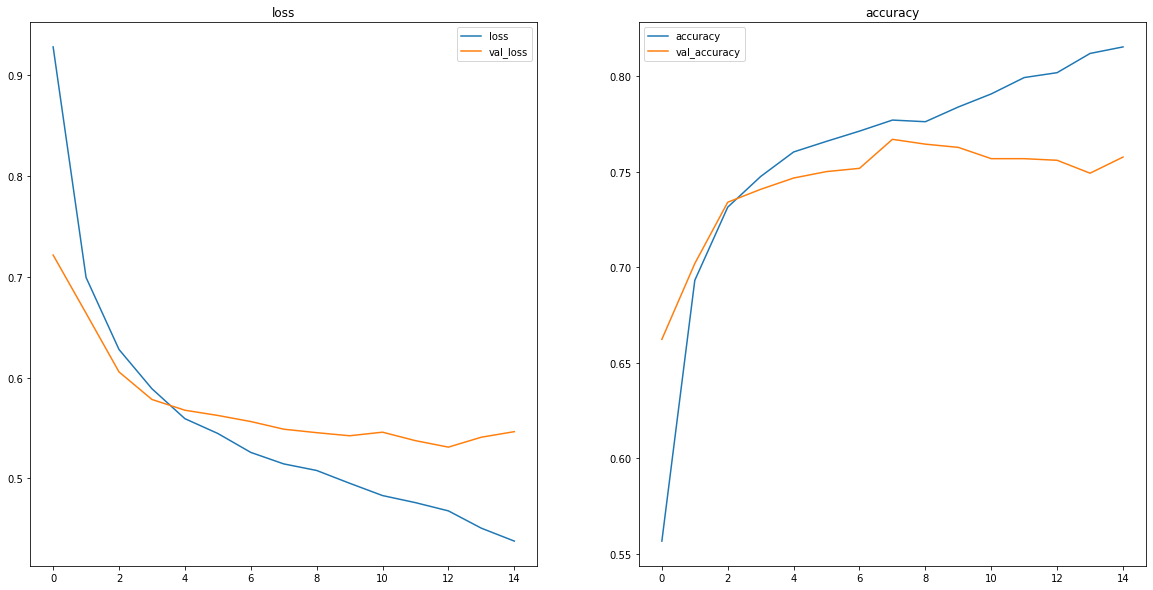

In [13]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(121)
for k in ['loss', 'val_loss']:
  plt.plot(history.history[k], label=k)
plt.legend()
plt.title('loss')
plt.subplot(122)
for k in ['accuracy', 'val_accuracy']:
  plt.plot(history.history[k], label=k)
plt.legend()
plt.title('accuracy')
plt.show()

In [ ]:
# the training is not excellent, we can observe that the two curves separate from each other after 
# the epoch 8 or 9. We can suppose that there is a overfitting after. It should be better to stop the training
# before
# The two curves are not very close and therefore we can suppose that the training quality is poor
# The accuracy is around 75% 
# In the following, we will plot the two confusion matrices to control the accuracy 

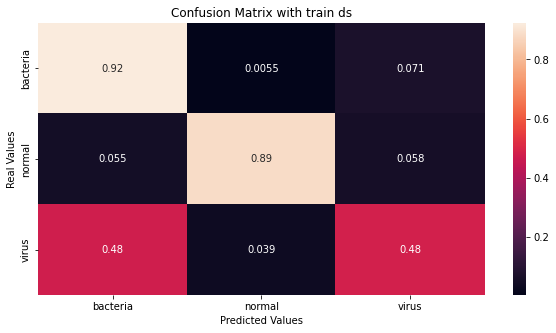

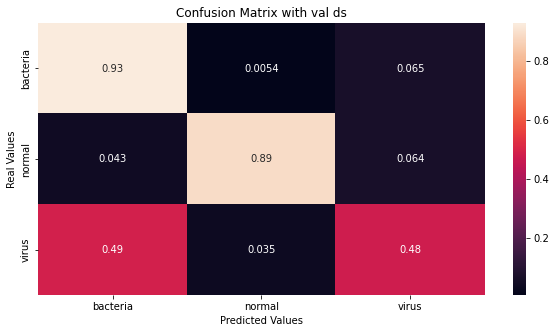

In [36]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
# plotting confusion matrix
# doing prediction
def doing_predictions(ds, network):
  label = []  
  predictions = []
  for img, lab in ds:
    label += [lab.numpy()]
    predictions += [network.predict(img)]
  label = np.concatenate(label, axis=0)
  predictions = np.argmax(np.concatenate(predictions, axis=0), axis=1)
  return label, predictions

plt.rcParams['figure.figsize'] = [10, 5]
def confusion_matrix_plot(y, ypred, what=''):
  mat = confusion_matrix(y, ypred, normalize='true')
  ax = sns.heatmap(mat, annot=True)
  ax.set_title('Confusion Matrix {}'.format(what));
  ax.set_xlabel('Predicted Values')
  ax.set_ylabel('Real Values');
  ax.xaxis.set_ticklabels(ds.class_names)
  ax.yaxis.set_ticklabels(ds.class_names)
  
y, ypred = doing_predictions(ds_train, net)
confusion_matrix_plot(y, ypred, 'with train ds')
plt.show()

y, ypred = doing_predictions(ds_val, net)
confusion_matrix_plot(y, ypred, 'with val ds')
plt.show()

In [ ]:
# FIRST CONCLUSION ******

# the two confusion matrices show that the accuracy is satisfactory for label normal and bacteria,
# with a score close to 90% for train and val dataset. However, the accuracy obtained for the class
# virus is poor with a score of 48% but the misclassification is with the class bacteria 49%. 
# We can conclude that the model predicts with a high score (>90%) if a patient is sick or not.
# if the prediction is Virus, the patient has an important probability to have a viral pneumonia 
# if the prediction is Bacteria, the patient has an important probability to have a pneumonia, but the
# origin (virus or bacteria) is not clear

# if the patient does not have a pneumonia, 89% of cases are correctly detected
# if the patient has a bacterial pneumonia, 93% of cases are correctly detected and 6% are misclassified as viral 
# pneumonia 
# if the patient has a viral pneumonia, the pneumonia is detected in 97% of cases, but the origin is unknown 

# we test our model using a 5-fold cross-validation and limiting the number of epochs to 8

In [19]:
# testing the model with k-fold cross-valisation
# with k = 5
# split the dataset into 5 parts

# creation of K sub esuivalent datasets
K = 5
ds_parts = []
sub_size = 1.0 / K
for i in range(K):
  start = i * sub_size
  sub = ds.skip(int(start * len(ds)))
  ds_parts += [sub.take(int(sub_size * len(ds)))]

# for each training, creation of a train dataset
# and a validation dataset 
K_fold = list(range(K))
histories = {}
scores = {}
epochs = 8
for i in range(K):
  itrain = K_fold[:i] + K_fold[(i+1):]
  ds_train = ds_parts[itrain[0]]
  for j in range(1, K-1):
    ds_train = ds_train.concatenate(ds_parts[itrain[j]])
  ds_val = ds_parts[K_fold[i]]

  ds_train = ds_train.map(map_func=preprocess_1, 
                          num_parallel_calls=tf.data.AUTOTUNE).cache().\
                          prefetch(buffer_size=tf.data.AUTOTUNE)
  ds_val = ds_val.map(map_func=preprocess_1, 
                      num_parallel_calls=tf.data.AUTOTUNE).cache().\
                      prefetch(buffer_size=tf.data.AUTOTUNE)

  seed = 13475
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  tf.random.set_seed(seed)
  np.random.seed(seed)

  # creation of a model
  net = ML_model([image_h, image_w, image_c], len(labels), 
               CNN_blocks=[3, 4, 8, 16, 32], 
               activation_fct='relu', pad="valid", dropout=0.00,
               linear_part=[64],
               activation_fct2=tf.nn.leaky_relu)
  
  net.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #"categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])
  
  history = net.fit(ds_train,
                  epochs=epochs,
                  validation_data=ds_val,
                  callbacks=[reduce_lr])
  
  histories[i] = history
  scores[i] = net.evaluate(ds_val, verbose=0)


Epoch 1/8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


144/144 [==============================] - 29s 182ms/step - loss: 0.8354 - accuracy: 0.6137 - val_loss: 0.7126 - val_accuracy: 0.6892 - lr: 5.0000e-04
Epoch 2/8
144/144 [==============================] - 2s 13ms/step - loss: 0.6357 - accuracy: 0.7227 - val_loss: 0.5975 - val_accuracy: 0.7405 - lr: 5.0000e-04
Epoch 3/8
144/144 [==============================] - 2s 12ms/step - loss: 0.5873 - accuracy: 0.7457 - val_loss: 0.5971 - val_accuracy: 0.7431 - lr: 5.0000e-04
Epoch 4/8
144/144 [==============================] - 2s 12ms/step - loss: 0.5645 - accuracy: 0.7567 - val_loss: 0.5829 - val_accuracy: 0.7526 - lr: 5.0000e-04
Epoch 5/8
144/144 [==============================] - 2s 12ms/step - loss: 0.5444 - accuracy: 0.7687 - val_loss: 0.5761 - val_accuracy: 0.7543 - lr: 5.0000e-04
Epoch 6/8
144/144 [==============================] - 2s 12ms/step - loss: 0.5316 - accuracy: 0.7750 - val_loss: 0.5499 - val_accuracy: 0.7656 - lr: 5.0000e-04
Epoch 7/8
144/144 [==============================] - 2

In [ ]:
# We plot the loss and accuracy curves of each training, to check if the beahvior of each models are close

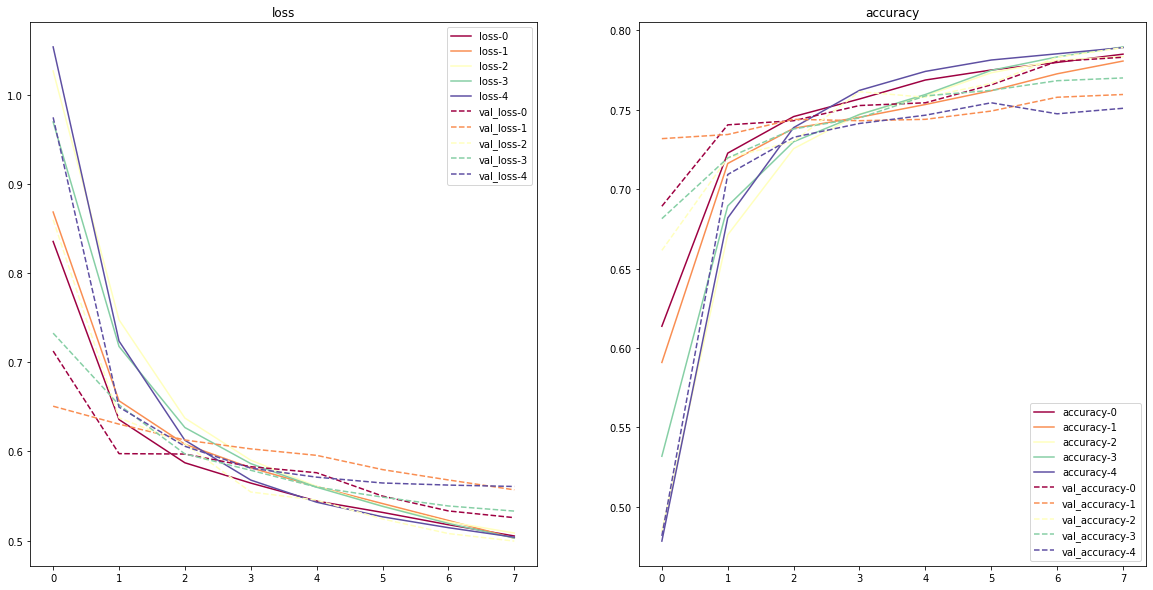

In [20]:
plt.rcParams['figure.figsize'] = [20, 10]
cmap = plt.matplotlib.cm.get_cmap('Spectral')
co = [cmap(x) for x in np.linspace(0, 1, len(histories))]

plt.subplot(121)
for k, st in zip(['loss', 'val_loss'], ['solid', 'dashed']):
  for h, c in zip(histories, co):
    plt.plot(histories[h].history[k], label=k + '-' + str(h), c=c, 
             linestyle=st)
plt.legend()
plt.title('loss')
plt.subplot(122)
for k, st in zip(['accuracy', 'val_accuracy'], ['solid', 'dashed']):
  for h, c in zip(histories, co):
    plt.plot(histories[h].history[k], label=k + '-' + str(h), c=c, 
             linestyle=st)
plt.legend()
plt.title('accuracy')
plt.show()

In [ ]:
# to obtain a good representation, we evaluate the mean and the standart deviation and we plot them

In [21]:
merge = {}
for t in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:
  merge[t] = []
for h in histories:
  for t in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:
    merge[t] += [histories[h].history[t]]

means = {}
stds = {}
for t in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:
  merge[t] = np.stack(merge[t], axis=0)
  stds[t] = np.std(merge[t], axis=0)
  means[t] = np.mean(merge[t], axis=0)

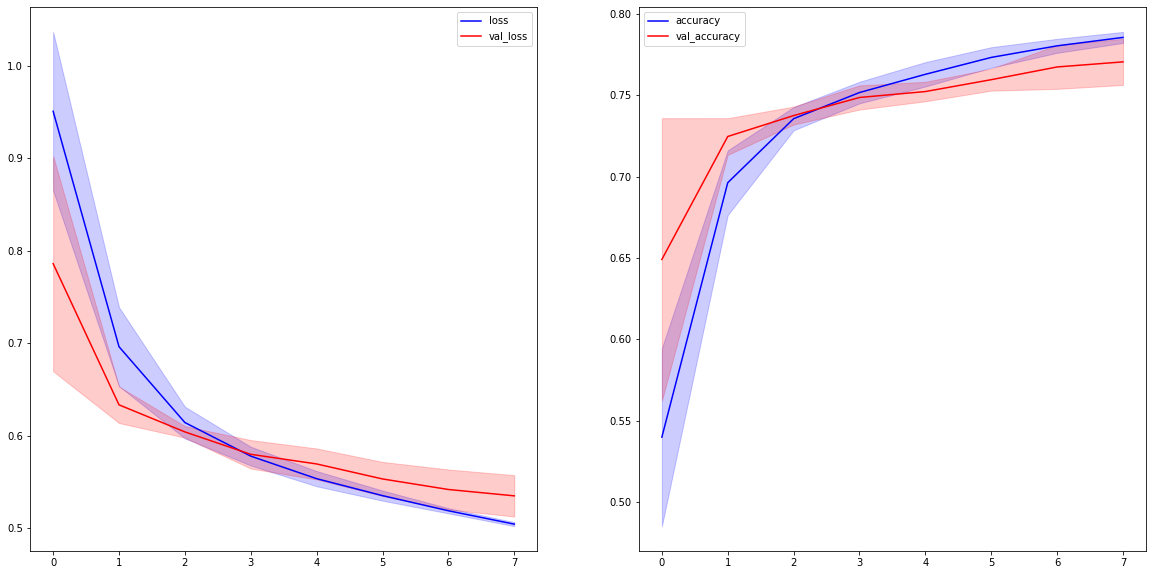

In [22]:
x = np.arange(merge['loss'].shape[1])
plt.subplot(121)
for t, c in zip(['loss', 'val_loss'], ['b', 'r']):
  plt.plot(means[t], c, label=t)
  plt.fill_between(x, means[t] - stds[t], means[t] + stds[t], color=c, alpha=0.2)
plt.legend()
plt.subplot(122)
for t, c in zip(['accuracy', 'val_accuracy'], ['b', 'r']):
  plt.plot(means[t], c, label=t)
  plt.fill_between(x, means[t] - stds[t], means[t] + stds[t], color=c, alpha=0.2)
plt.legend()
plt.show()

In [ ]:
# the curves obtained show that the model works in the same way for each fold and it is stable.
# we finish training a new model with all the dataset 

In [25]:
# final training
ds_train = ds_parts[0]
for j in range(1, K):
  ds_train = ds_train.concatenate(ds_parts[j])

ds_train = ds_train.map(map_func=preprocess_1, 
                        num_parallel_calls=tf.data.AUTOTUNE).cache().\
                        prefetch(buffer_size=tf.data.AUTOTUNE)


seed = 13475
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# creation of a model
net = ML_model([image_h, image_w, image_c], len(labels), 
            CNN_blocks=[3, 4, 8, 16, 32], 
            activation_fct='relu', pad="valid", dropout=0.00,
            linear_part=[64],
            activation_fct2=tf.nn.leaky_relu)

net.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #"categorical_crossentropy", 
            optimizer=optimizer,
            metrics=["accuracy"])

history = net.fit(ds_train,
                epochs=epochs,
                validation_data=ds_train,  # validation over train ds
                callbacks=[reduce_lr])

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


180/180 [==============================] - 30s 161ms/step - loss: 1.0598 - accuracy: 0.4766 - val_loss: 1.0557 - val_accuracy: 0.4767 - lr: 5.0000e-04
Epoch 2/8
180/180 [==============================] - 3s 17ms/step - loss: 0.8114 - accuracy: 0.6366 - val_loss: 0.6269 - val_accuracy: 0.7382 - lr: 5.0000e-04
Epoch 3/8
180/180 [==============================] - 3s 16ms/step - loss: 0.6152 - accuracy: 0.7373 - val_loss: 0.5709 - val_accuracy: 0.7545 - lr: 5.0000e-04
Epoch 4/8
180/180 [==============================] - 3s 17ms/step - loss: 0.5733 - accuracy: 0.7552 - val_loss: 0.5400 - val_accuracy: 0.7722 - lr: 5.0000e-04
Epoch 5/8
180/180 [==============================] - 3s 17ms/step - loss: 0.5409 - accuracy: 0.7648 - val_loss: 0.5210 - val_accuracy: 0.7800 - lr: 5.0000e-04
Epoch 6/8
180/180 [==============================] - 3s 17ms/step - loss: 0.5154 - accuracy: 0.7769 - val_loss: 0.5025 - val_accuracy: 0.7866 - lr: 5.0000e-04
Epoch 7/8
180/180 [==============================] - 3

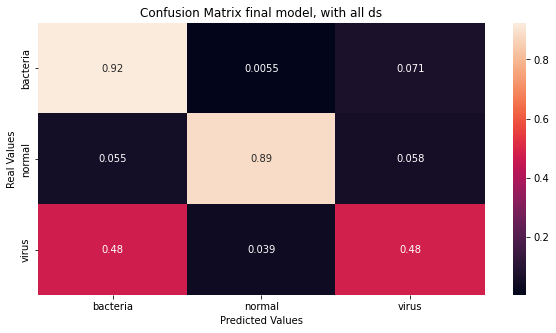

In [37]:
y, ypred = doing_predictions(ds_train, net)
confusion_matrix_plot(y, ypred, "final model, with all ds")
plt.show()

In [ ]:
# The model obtained has the same behavior that the first one (but it is tested with the 
# training dataset)
# the detection of a pneumonia has a high score, but some viral cases are misclassified as bacterial
# pneumonia